# LFP Tutorial 2 - Active Cell
This second tutorial in the LFP series is to demonstrate how the situation changes when we add active channels. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below or click the "Run" button above.

In [1]:
%%capture 
import LFPy # LFPy for modeling the cell with NEURON

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We will begin by building our cell from a template, which is contained in this directory. This cell is modeled as a cylinder that is 150 um long and will have 5 segments, each 30 um long. The canonical circuit diagram for a passive compartmental model is given below. Here we are focused on the so-called "transmembrane current" which is the sum of the capacitive current plus leak current, and is denoted here by $I_{mn}$: where n is the segment number.
<img src="circuit.png">

## Define cell and simulation parameters
We need to define the parameters of the cell, seen in the circuit above. These are the membrane capacitance (cm), leak conductance (g_pas), leak reversal potential (e_pas), and axial resistance per unit length (Ra). We will apply a synapse to Segment 1, as shown in the circuit as an independent current source. The parameters for the synapse are also defined here.

Then we will create a "grid" of extracellular electrodes which will be used to calculate the extracellular potential.

In [3]:
cellParameters = {
    'morphology' : 'single_section_active.hoc',
    'tstart' : -50,
    'tstop' : 100,
    'dt' : 2**-4,
    'nsegs_method': 'fixed_length',
    'max_nsegs_length':101,
    'Ra':150,
    'cm':1,
    'verbose':True
}

SynapseParameters = {
    'syntype' : 'Exp2Syn',
    'e' : -20,
    'tau1' : 0.5,
    'tau2' : 2.0,
    'weight' : 0.012,
    'record_current' : True,
}

z = mgrid[-400:1201:100]
electrodeParameters = {
    'x' : zeros(z.size),
    'y' : zeros(z.size),
    'z' : z,
    'sigma' : 0.3,
}

Then, create the **cell**, **synapse** and **electrode** objects using 
**LFPy.Cell**, **LFPy.Synapse**, **LFPy.RecExtElectrode**.

In [4]:
cell = LFPy.Cell(**cellParameters)
cell.set_pos(x=-250, y=0, z=0)
cell.set_rotation(z=np.pi)

# Synapse
synapse = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(x=-250,z=500),
                       **SynapseParameters)

# Synapse will be applied at 50 ms
synapse.set_spike_times(array([50]))       

# Create electrode
electrode = LFPy.RecExtElectrode(**electrodeParameters)

No passive properties added
no extracellular mechanism inserted
Total number of segments: 5
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Geometry not rotated around z-axis
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Geometry not rotated around z-axis
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Geometry not rotated around z-axis
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Geometry not rotated around z-axis
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Geometry not rotated around z-axis
Geometry not rotated around x-axis
Geometry not rotated around y-axis
Rotated geometry 3.14159 radians around z-axis


Run the simulation with **electrode** as input to **cell.simulate()**

In [5]:
cell.simulate(electrode=electrode,rec_imem=True,rec_icap=True,rec_ipas=True,rec_vmem=True,rec_variables=['ina','ik'])

precalculating geometry - LFP mapping
t = 50, realtime factor: 5.080
collected recorded variable ina
collected recorded variable ik


Then plot the **somatic potential** and the **LFP**
from electrode object:

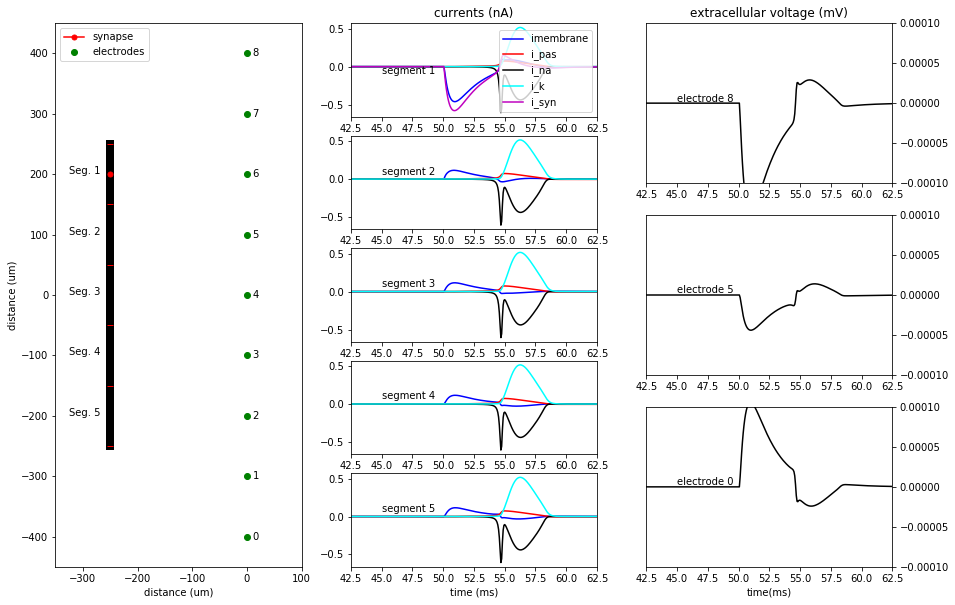

In [6]:
import utils
utils.Plot_active_currs_volt(cell,electrode,synapse)

## Verify that the currents add up
By Kirchoff's current law (i.e. law of conservation of charge) all of the currents in a compartment must sum to zero. Let's remember the circuit:
<img src="circuit.png">


This means that $I_{mn}$ = $I_{capn}$ + $I_{pasn}$ + $I_{syn}$. In this case there is only synaptic current in one segment so $I_{syn}$ only appears in segment 1. Let's verify that the currents add up to the transmembrane current.

(35, 75)

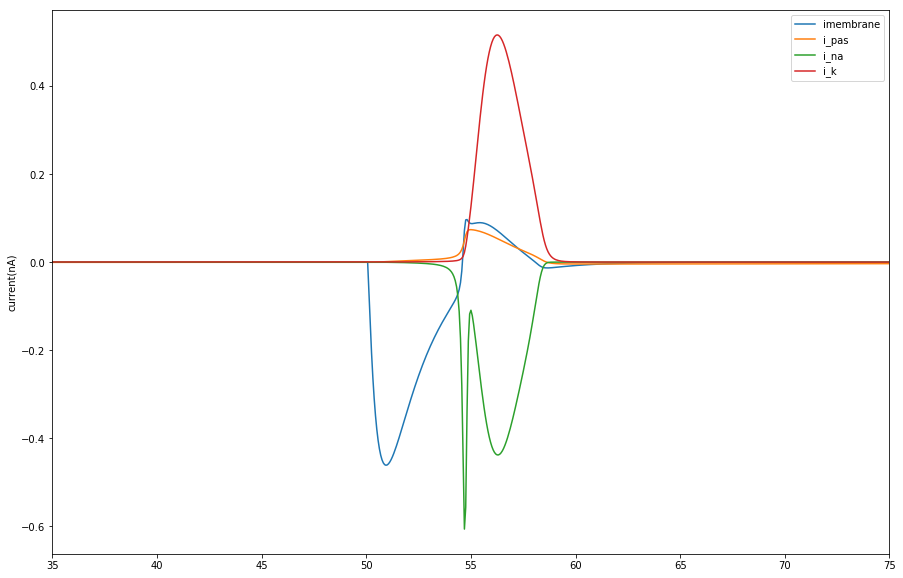

In [7]:
cell.get_axial_currents_from_vmem
segment = 1# Segment to verify
figure(figsize=(15, 10))
#subplot(2,1,1)
plot(cell.tvec,cell.imem[5-segment,:],label='imembrane')
plot(cell.tvec,cell.ipas[5-segment,:],label='i_pas')
#plot(cell.tvec,cell.icap[5-segment,:],label='i_cap')
plot(cell.tvec,cell.rec_variables['ina'][5-segment,:],label='i_na')
plot(cell.tvec,cell.rec_variables['ik'][5-segment,:],label='i_k')
#pas_cap = cell.ipas[5-segment,:]+cell.icap[5-segment,:]
#plot(cell.tvec,pas_cap,'m',label='i_pas+i_cap')
ylabel('current(nA)')
legend()
xlim(35,75)
#ylim(-0.9,0.5)

#subplot(2,1,2)
#plot(cell.tvec,pas_cap-cell.imem[5-segment,:])
#xlabel('time(ms)')
#ylabel('error')
#xlim(45,65)

There is some error but at most it is ~0.04% of I_mem, which is probably due to differences in numerical precision.

(45, 65)

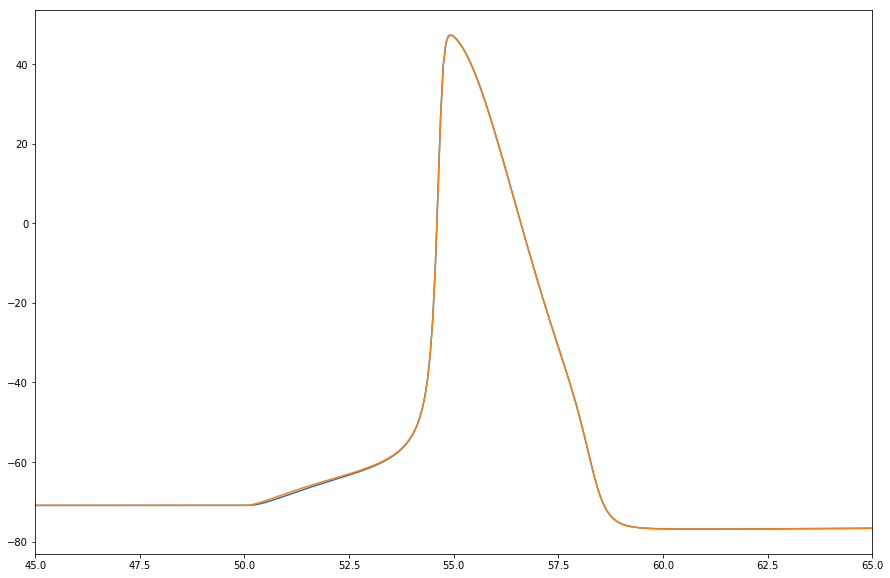

In [8]:
figure(figsize=(15, 10))
plot(cell.tvec,cell.vmem[0,:])
plot(cell.tvec,cell.vmem[-1,:])
xlim(45,65)

(<matplotlib.collections.QuadMesh at 0x7fea1fd9e410>,
 Text(0.5,1,'LFP (mV)'))

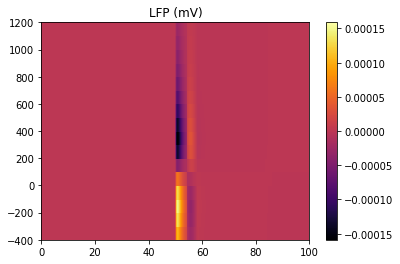

In [9]:
pcolormesh(cell.tvec, electrode.z, electrode.LFP,
           vmin=-abs(electrode.LFP).max(), vmax=abs(electrode.LFP).max(),
           cmap='inferno'), colorbar(), title('LFP (mV)')